# ResNet-18 with Triplet Loss

This notebook evaluates the effect of using Triplet Loss on pre-trained ResNet18 model performance.

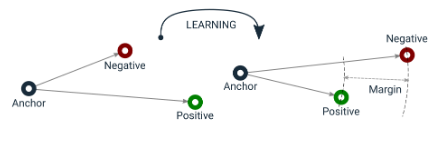

Triplet loss is a loss function that encourages images from the same class to converge closer together and images from different classes to be further apart. It operates on anchor, positive and negative samples, reducing the distance between anchor and positive samples and increasing distance between anchor and negative samples.This improves class separability and fine-grained recognition, which is important for Flowers102 dataset where flower species might only have subtle inter-class visual differences but large intra-class variation.

Building on the final baseline model for ResNet18, a custom triplet data sampling is used to form anchor-positive-negative tuples for the mini-batches. Instead of only logits, the network creates a low-dimensional embedding. Two variations were tested. The triplet loss variant uses only Triplet Margin Loss (with a fixed margin of 1.0) as the loss function, and classification accuracy is determined by fitting a k Nearest Neighbours classifier (with k = 5) on the learned embeddings. The triplet loss plus cross-entropy variant uses and computes a weighted sum of both Triplet Margin Loss (with a fixed margin of 1.0) and Cross Entropy Loss as the loss function for optimization. The test accuracy is computed directly using the classifier’s predictions. Since this section focuses on geometry in the feature space, we used t-SNE of embeddings to visualise their performance on test set, by projecting the high-dimensional embeddings into a 2D space to inspect structures like clusters and overlaps. 


## Imports and Reproducibility Setup 

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets, models
from torchvision.datasets import Flowers102
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.transforms import v2
from torch.utils.data import DataLoader, default_collate

import matplotlib.pyplot as plt
import random
import numpy as np
from itertools import product
import copy, time

from torch.utils.data import Dataset
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE

# For reproducibility
seed = 1001
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
rng = np.random.default_rng(seed)


## Data Preparation and Helper Functions

In [3]:
# Using best config from baseline model
BEST_LR = 5e-4
BEST_BATCH_SIZE = 32
BEST_DROPOUT = 0.3
BEST_WEIGHT_DECAY = 1e-04
BEST_PATIENCE = 5
EMBED_DIM = 256

NUM_CLASSES = 102

In [4]:
# resize images to 224x224 in line with ResNet input size, normalize images so mean and std are in line with pretrained statistics
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
# load the dataset
train_dataset = datasets.Flowers102(root='./data', split='train', download=True, transform=transform)
val_dataset = datasets.Flowers102(root='./data', split='val', download=True, transform=transform)
test_dataset = datasets.Flowers102(root='./data', split='test', download=True, transform=transform)

In [6]:
# create data loaders
# Use tuned batch size from baseline search

train_loader = DataLoader(train_dataset, batch_size=BEST_BATCH_SIZE, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=BEST_BATCH_SIZE, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=BEST_BATCH_SIZE, shuffle=False, num_workers=0)

In [6]:
# Triplet Dataset Wrapper
class TripletDataset(Dataset):
    """
    Wraps a labeled dataset (img, label) -> returns (anchor, pos, neg, anchor_label)
    """
    def __init__(self, base_dataset):
        self.base = base_dataset
        self.labels = [y for _, y in base_dataset]
        self.labels = np.array(self.labels)
        self.label_to_indices = {}
        for idx, y in enumerate(self.labels):
            self.label_to_indices.setdefault(int(y), []).append(idx)

        self.classes = sorted(list(self.label_to_indices.keys()))

    def __len__(self):
        return len(self.base)

    def __getitem__(self, index):
        anchor_img, anchor_label = self.base[index]
        anchor_label = int(anchor_label)

        # positive sample (same class, different index)
        pos_indices = self.label_to_indices[anchor_label]
        if len(pos_indices) > 1:
            pos_index = index
            while pos_index == index:
                pos_index = random.choice(pos_indices)
        else:
            pos_index = index
        pos_img, _ = self.base[pos_index]

        # negative sample (different class)
        neg_label = anchor_label
        while neg_label == anchor_label:
            neg_label = random.choice(self.classes)
        neg_index = random.choice(self.label_to_indices[neg_label])
        neg_img, _ = self.base[neg_index]

        return anchor_img, pos_img, neg_img, anchor_label



In [7]:
triplet_train_dataset = TripletDataset(train_dataset)
triplet_val_dataset   = TripletDataset(val_dataset)
triplet_test_dataset  = TripletDataset(test_dataset)



In [8]:
triplet_train_loader = DataLoader(triplet_train_dataset, batch_size=BEST_BATCH_SIZE,
                                  shuffle=True, num_workers=0)
triplet_val_loader   = DataLoader(triplet_val_dataset,   batch_size=BEST_BATCH_SIZE,
                                  shuffle=False, num_workers=0)
triplet_test_loader  = DataLoader(triplet_test_dataset,  batch_size=BEST_BATCH_SIZE,
                                  shuffle=False, num_workers=0)


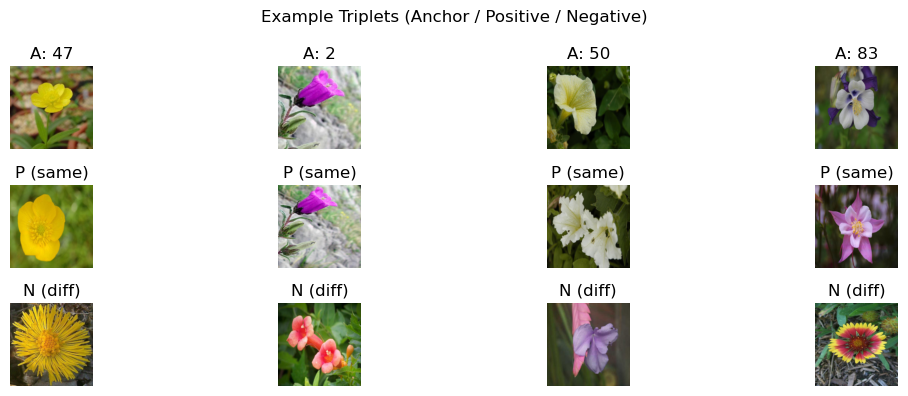

In [9]:
# Visualise Example Triplets 

inv_mean = np.array([0.485, 0.456, 0.406])
inv_std  = np.array([0.229, 0.224, 0.225])

def denormalize(t):
    img = t.detach().cpu().numpy().transpose(1, 2, 0)
    img = img * inv_std + inv_mean
    return np.clip(img, 0, 1)

def show_triplet_batch(loader, num_triplets=4):
    anchor, pos, neg, labels = next(iter(loader))
    num = min(num_triplets, anchor.size(0))

    plt.figure(figsize=(12, 4))
    for i in range(num):
        # anchor
        ax = plt.subplot(3, num, i + 1)
        ax.imshow(denormalize(anchor[i]))
        ax.set_title(f"A: {labels[i].item()}")
        ax.axis("off")

        # positive
        ax = plt.subplot(3, num, num + i + 1)
        ax.imshow(denormalize(pos[i]))
        ax.set_title("P (same)")
        ax.axis("off")

        # negative
        ax = plt.subplot(3, num, 2 * num + i + 1)
        ax.imshow(denormalize(neg[i]))
        ax.set_title("N (diff)")
        ax.axis("off")
    plt.suptitle("Example Triplets (Anchor / Positive / Negative)")
    plt.tight_layout()
    plt.show()

show_triplet_batch(triplet_train_loader)


In [10]:
# Models

class ResNet18Embedding(nn.Module):
    """
    ResNet-18 backbone -> EMBED_DIM embedding (for Triplet).
    """
    def __init__(self, embedding_dim=EMBED_DIM, dropout_p=BEST_DROPOUT):
        super().__init__()
        weights = ResNet18_Weights.DEFAULT
        base = resnet18(weights=weights)
        in_features = base.fc.in_features
        base.fc = nn.Identity()
        self.backbone = base
        self.embedding = nn.Sequential(
            nn.Dropout(dropout_p),
            nn.Linear(in_features, embedding_dim)
        )

    def forward(self, x):
        feats = self.backbone(x)
        emb = self.embedding(feats)
        return emb


class ResNet18TripletCE(nn.Module):
    """
    Joint model:
    - ResNet18 backbone
    - EMBED_DIM embedding for Triplet loss
    - 102-way classifier head for CE
    """
    def __init__(self, embedding_dim=EMBED_DIM, num_classes=NUM_CLASSES, dropout_p=BEST_DROPOUT):
        super().__init__()
        weights = ResNet18_Weights.DEFAULT
        base = resnet18(weights=weights)
        in_features = base.fc.in_features
        base.fc = nn.Identity()
        self.backbone = base
        self.embedding = nn.Sequential(
            nn.Dropout(dropout_p),
            nn.Linear(in_features, embedding_dim)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_p),
            nn.Linear(embedding_dim, num_classes)
        )

    def forward(self, x):
        feats = self.backbone(x)
        emb = self.embedding(feats)
        logits = self.classifier(emb)
        return logits, emb


def build_baseline_resnet18(dropout_p=BEST_DROPOUT, num_classes=NUM_CLASSES):
    weights = ResNet18_Weights.DEFAULT
    model = resnet18(weights=weights)
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(dropout_p),
        nn.Linear(in_features, num_classes)
    )
    return model


In [11]:
# Losses & Early Stopping & ECE

triplet_loss_fn = nn.TripletMarginLoss(margin=1.0, p=2)

class EarlyStopper:
    def __init__(self, patience=BEST_PATIENCE, min_delta=0.0, model_path=None, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best = None
        self.model_path = model_path
        self.verbose = verbose

    def step(self, metric, model):
        if self.best is None or metric < self.best - self.min_delta:
            self.best = metric
            self.counter = 0
            if self.model_path is not None:
                torch.save(model.state_dict(), self.model_path)
        else:
            self.counter += 1

        if self.counter >= self.patience:
            if self.verbose:
                print("Early stopping triggered.")
            return True
        return False

def compute_ece(model, loader, n_bins=15):
    model.eval()
    confidences = []
    accuracies = []

    with torch.no_grad():
        for X, y in loader:
            logits = model(X)
            if isinstance(logits, tuple):  # for joint model (logits, emb)
                logits = logits[0]
            probs = F.softmax(logits, dim=1)
            conf, preds = probs.max(dim=1)
            confidences.append(conf.cpu())
            accuracies.append((preds == y).float().cpu())

    confidences = torch.cat(confidences)
    accuracies = torch.cat(accuracies)

    ece = torch.zeros(1)
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)

    for i in range(n_bins):
        start = bin_boundaries[i]
        end = bin_boundaries[i+1]
        in_bin = (confidences > start) & (confidences <= end)
        prop = in_bin.float().mean()
        if prop.item() > 0:
            acc_bin = accuracies[in_bin].mean()
            conf_bin = confidences[in_bin].mean()
            ece += torch.abs(conf_bin - acc_bin) * prop

    return float(ece.item())


In [12]:
# Training Functions for Variants

def train_baseline_ce(
    num_epochs=30,
    lr=BEST_LR,
    weight_decay=BEST_WEIGHT_DECAY,
    model_path="resnet18_triplet_baseline_ce.pth"
):
    model = build_baseline_resnet18()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay,foreach=False)
    criterion = nn.CrossEntropyLoss()
    early = EarlyStopper(patience=BEST_PATIENCE, model_path=model_path)

    tr_loss_hist, tr_acc_hist = [], []
    val_loss_hist, val_acc_hist = [], []

    for epoch in range(1, num_epochs + 1):
        # ---- train ----
        model.train()
        run_loss, correct, total = 0.0, 0, 0
        for X, y in train_loader:
            optimizer.zero_grad()
            logits = model(X)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            run_loss += loss.item() * X.size(0)
            _, preds = logits.max(1)
            correct += (preds == y).sum().item()
            total += X.size(0)

        tr_loss = run_loss / total
        tr_acc = correct / total
        tr_loss_hist.append(tr_loss)
        tr_acc_hist.append(tr_acc)

        # ---- val ----
        model.eval()
        run_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for X, y in val_loader:
                logits = model(X)
                loss = criterion(logits, y)
                run_loss += loss.item() * X.size(0)
                _, preds = logits.max(1)
                correct += (preds == y).sum().item()
                total += X.size(0)

        val_loss = run_loss / total
        val_acc = correct / total
        val_loss_hist.append(val_loss)
        val_acc_hist.append(val_acc)

        print(f"[Baseline CE] Epoch {epoch} | "
              f"Train Loss: {tr_loss:.4f}/ Train Acc: {tr_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}/ Val Acc: {val_acc:.4f}")

        if early.step(val_loss, model):
            break

    # load best
    best_model = build_baseline_resnet18()
    best_model.load_state_dict(torch.load(model_path))
    best_model.eval()

    # test
    test_loss, test_acc = evaluate_classifier(best_model, test_loader)

    return {
        "model": best_model,
        "train_loss": tr_loss_hist,
        "train_acc": tr_acc_hist,
        "val_loss": val_loss_hist,
        "val_acc": val_acc_hist,
        "best_val_acc": max(val_acc_hist),
        "test_acc": test_acc,
        "val_ece": compute_ece(best_model, val_loader),
        "test_ece": compute_ece(best_model, test_loader),
        "model_path": model_path,
    }

def evaluate_classifier(model, loader):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    run_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for X, y in loader:
            logits = model(X)
            if isinstance(logits, tuple):  # (logits, emb)
                logits = logits[0]
            loss = criterion(logits, y)
            run_loss += loss.item() * X.size(0)
            _, preds = logits.max(1)
            correct += (preds == y).sum().item()
            total += X.size(0)
    return run_loss / total, correct / total

def extract_embeddings(model, loader, joint=False):
    model.eval()
    embs, labels = [], []
    with torch.no_grad():
        for X, y in loader:
            if joint:
                logits, z = model(X)
                emb = z
            else:
                emb = model(X)
            embs.append(emb.cpu())
            labels.append(y)
    embs = torch.cat(embs).numpy()
    labels = torch.cat(labels).numpy()
    return embs, labels

def train_triplet_only(
    num_epochs=30,
    lr=BEST_LR,
    weight_decay=BEST_WEIGHT_DECAY,
    model_path="resnet18_triplet_only.pth"
):
    model = ResNet18Embedding()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay,foreach=False)
    early = EarlyStopper(patience=BEST_PATIENCE, model_path=model_path)

    tr_loss_hist, tr_acc_hist = [], []
    val_loss_hist, val_acc_hist = [], []

    for epoch in range(1, num_epochs + 1):
        # ---- train ----
        model.train()
        run_loss, correct, total = 0.0, 0, 0
        for a, p, n, _ in triplet_train_loader:
            optimizer.zero_grad()
            za = model(a)
            zp = model(p)
            zn = model(n)
            loss = triplet_loss_fn(za, zp, zn)
            loss.backward()
            optimizer.step()

            run_loss += loss.item() * a.size(0)

            # triplet "accuracy": d(a,p) < d(a,n)
            dist_pos = (za - zp).pow(2).sum(1)
            dist_neg = (za - zn).pow(2).sum(1)
            correct += (dist_pos < dist_neg).sum().item()
            total += a.size(0)

        tr_loss = run_loss / total
        tr_acc = correct / total
        tr_loss_hist.append(tr_loss)
        tr_acc_hist.append(tr_acc)

        # ---- val ----
        model.eval()
        run_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for a, p, n, _ in triplet_val_loader:
                za = model(a)
                zp = model(p)
                zn = model(n)
                loss = triplet_loss_fn(za, zp, zn)
                run_loss += loss.item() * a.size(0)
                dist_pos = (za - zp).pow(2).sum(1)
                dist_neg = (za - zn).pow(2).sum(1)
                correct += (dist_pos < dist_neg).sum().item()
                total += a.size(0)

        val_loss = run_loss / total
        val_acc = correct / total
        val_loss_hist.append(val_loss)
        val_acc_hist.append(val_acc)

        print(f"[Triplet-only] Epoch {epoch} | "
              f"Train Loss: {tr_loss:.4f}/ Train Acc: {tr_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}/ Val Acc: {val_acc:.4f}")

        # early stopping on validation loss (metric learning)
        if early.step(val_loss, model):
            break

    # load best
    best_model = ResNet18Embedding()
    best_model.load_state_dict(torch.load(model_path))
    best_model.eval()

    # kNN classification using embeddings
    train_embs, train_labels = extract_embeddings(best_model, train_loader, joint=False)
    val_embs, val_labels     = extract_embeddings(best_model, val_loader, joint=False)
    test_embs, test_labels   = extract_embeddings(best_model, test_loader, joint=False)

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(np.concatenate([train_embs, val_embs], axis=0),
            np.concatenate([train_labels, val_labels], axis=0))
    knn_test_acc = (knn.predict(test_embs) == test_labels).mean()

    # For comparison: treat best_val_acc as best triplet-val metric
    best_val_triplet = max(val_acc_hist)

    return {
        "model": best_model,
        "train_loss": tr_loss_hist,
        "train_acc": tr_acc_hist,
        "val_loss": val_loss_hist,
        "val_acc": val_acc_hist,
        "best_val_acc": best_val_triplet,      # triplet metric
        "test_acc": knn_test_acc,              # kNN on embeddings
        "val_ece": None,
        "test_ece": None,
        "model_path": model_path,
        "knn": knn,
    }

def train_triplet_plus_ce(
    num_epochs=30,
    lr=BEST_LR,
    weight_decay=BEST_WEIGHT_DECAY,
    alpha_triplet=1.0,
    alpha_ce=1.0,
    model_path="resnet18_triplet_ce_joint.pth"
):
    model = ResNet18TripletCE()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay,foreach=False)
    ce_loss = nn.CrossEntropyLoss()
    early = EarlyStopper(patience=BEST_PATIENCE, model_path=model_path)

    tr_loss_hist, tr_acc_hist = [], []
    val_loss_hist, val_acc_hist = [], []

    for epoch in range(1, num_epochs + 1):
        # ---- train ----
        model.train()
        run_loss, correct, total = 0.0, 0, 0
        for a, p, n, y in triplet_train_loader:
            optimizer.zero_grad()
            logits_a, za = model(a)
            _, zp = model(p)
            _, zn = model(n)

            loss_t = triplet_loss_fn(za, zp, zn)
            loss_ce = ce_loss(logits_a, y)
            loss = alpha_triplet * loss_t + alpha_ce * loss_ce

            loss.backward()
            optimizer.step()

            run_loss += loss.item() * a.size(0)
            _, preds = logits_a.max(1)
            correct += (preds == y).sum().item()
            total += a.size(0)

        tr_loss = run_loss / total
        tr_acc = correct / total
        tr_loss_hist.append(tr_loss)
        tr_acc_hist.append(tr_acc)

        # ---- val (classification only on standard val set) ----
        model.eval()
        run_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for X, y in val_loader:
                logits, _ = model(X)
                loss = ce_loss(logits, y)
                run_loss += loss.item() * X.size(0)
                _, preds = logits.max(1)
                correct += (preds == y).sum().item()
                total += X.size(0)

        val_loss = run_loss / total
        val_acc = correct / total
        val_loss_hist.append(val_loss)
        val_acc_hist.append(val_acc)

        print(f"[Triplet+CE] Epoch {epoch} | "
              f"Train Loss: {tr_loss:.4f}/ Train Acc: {tr_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}/ Val Acc: {val_acc:.4f}")

        if early.step(val_loss, model):
            break

    # load best
    best_model = ResNet18TripletCE()
    best_model.load_state_dict(torch.load(model_path))
    best_model.eval()

    _, test_acc = evaluate_classifier(best_model, test_loader)
    val_ece = compute_ece(best_model, val_loader)
    test_ece = compute_ece(best_model, test_loader)

    return {
        "model": best_model,
        "train_loss": tr_loss_hist,
        "train_acc": tr_acc_hist,
        "val_loss": val_loss_hist,
        "val_acc": val_acc_hist,
        "best_val_acc": max(val_acc_hist),
        "test_acc": test_acc,
        "val_ece": val_ece,
        "test_ece": test_ece,
        "model_path": model_path,
    }


## Training Loop

Here are the variants tested:
| Variant       | 
|-----------------|
| CE Only   | 
| Triplet Only | 
| Triplet + CE | 

In [13]:
# Run All Variants

results = {}

# 1) Baseline CE classifier
results["Baseline_CE"] = train_baseline_ce()

# 2) Triplet-only (metric learning) + kNN
results["Triplet_only+kNN"] = train_triplet_only()

# 3) Joint Triplet + CE
results["Triplet+CE_joint"] = train_triplet_plus_ce()


[Baseline CE] Epoch 01 | Train Loss: 3.9658/ Train Acc: 0.1706 | Val Loss: 2.3399/ Val Acc: 0.4500
[Baseline CE] Epoch 02 | Train Loss: 1.7875/ Train Acc: 0.6127 | Val Loss: 1.4293/ Val Acc: 0.6745
[Baseline CE] Epoch 03 | Train Loss: 0.7957/ Train Acc: 0.8647 | Val Loss: 1.1278/ Val Acc: 0.7608
[Baseline CE] Epoch 04 | Train Loss: 0.3340/ Train Acc: 0.9627 | Val Loss: 0.8646/ Val Acc: 0.8118
[Baseline CE] Epoch 05 | Train Loss: 0.1539/ Train Acc: 0.9961 | Val Loss: 0.7132/ Val Acc: 0.8284
[Baseline CE] Epoch 06 | Train Loss: 0.0844/ Train Acc: 0.9980 | Val Loss: 0.6524/ Val Acc: 0.8569
[Baseline CE] Epoch 07 | Train Loss: 0.0527/ Train Acc: 1.0000 | Val Loss: 0.5524/ Val Acc: 0.8804
[Baseline CE] Epoch 08 | Train Loss: 0.0330/ Train Acc: 1.0000 | Val Loss: 0.5521/ Val Acc: 0.8686
[Baseline CE] Epoch 09 | Train Loss: 0.0216/ Train Acc: 1.0000 | Val Loss: 0.5248/ Val Acc: 0.8794
[Baseline CE] Epoch 10 | Train Loss: 0.0141/ Train Acc: 1.0000 | Val Loss: 0.5181/ Val Acc: 0.8863
[Baseline 

C:\Users\nguiy\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\nguiy\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\nguiy\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\nguiy\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\nguiy\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

[Triplet+CE] Epoch 01 | Train Loss: 5.2685/ Train Acc: 0.0284 | Val Loss: 4.0436/ Val Acc: 0.1402
[Triplet+CE] Epoch 02 | Train Loss: 4.4666/ Train Acc: 0.0843 | Val Loss: 3.4088/ Val Acc: 0.2637
[Triplet+CE] Epoch 03 | Train Loss: 3.9036/ Train Acc: 0.1549 | Val Loss: 2.9627/ Val Acc: 0.3353
[Triplet+CE] Epoch 04 | Train Loss: 3.3374/ Train Acc: 0.2343 | Val Loss: 2.5239/ Val Acc: 0.4167
[Triplet+CE] Epoch 05 | Train Loss: 2.7839/ Train Acc: 0.3167 | Val Loss: 2.0605/ Val Acc: 0.5127
[Triplet+CE] Epoch 06 | Train Loss: 2.1955/ Train Acc: 0.4304 | Val Loss: 1.6978/ Val Acc: 0.5951
[Triplet+CE] Epoch 07 | Train Loss: 1.7419/ Train Acc: 0.5608 | Val Loss: 1.4871/ Val Acc: 0.6520
[Triplet+CE] Epoch 08 | Train Loss: 1.4226/ Train Acc: 0.6471 | Val Loss: 1.3878/ Val Acc: 0.6618
[Triplet+CE] Epoch 09 | Train Loss: 1.0767/ Train Acc: 0.7353 | Val Loss: 1.1865/ Val Acc: 0.6912
[Triplet+CE] Epoch 10 | Train Loss: 0.8928/ Train Acc: 0.7784 | Val Loss: 1.0518/ Val Acc: 0.7324
[Triplet+CE] Epoch 1

## Data Visualisation and Plots

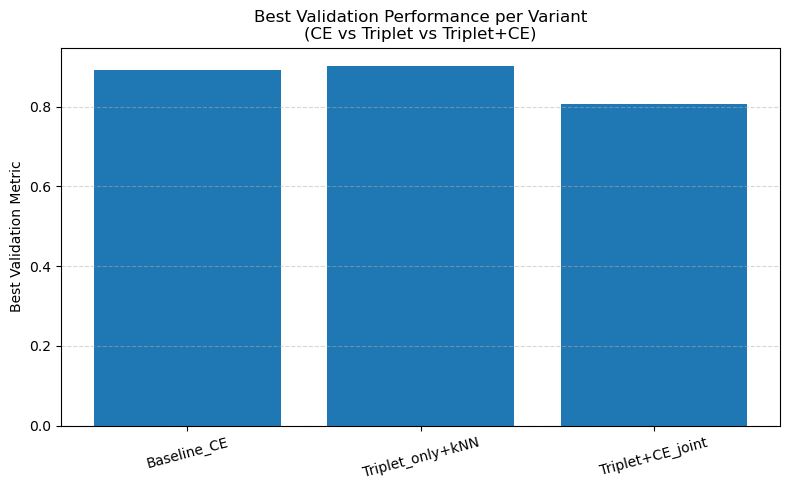

In [14]:
# Bar: Best validation accuracy per variant
variant_names = list(results.keys())
best_vals = [results[v]["best_val_acc"] for v in variant_names]

plt.figure(figsize=(8, 5))
plt.bar(variant_names, best_vals)
plt.ylabel("Best Validation Metric")
plt.title("Best Validation Performance per Variant\n(CE vs Triplet vs Triplet+CE)")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()



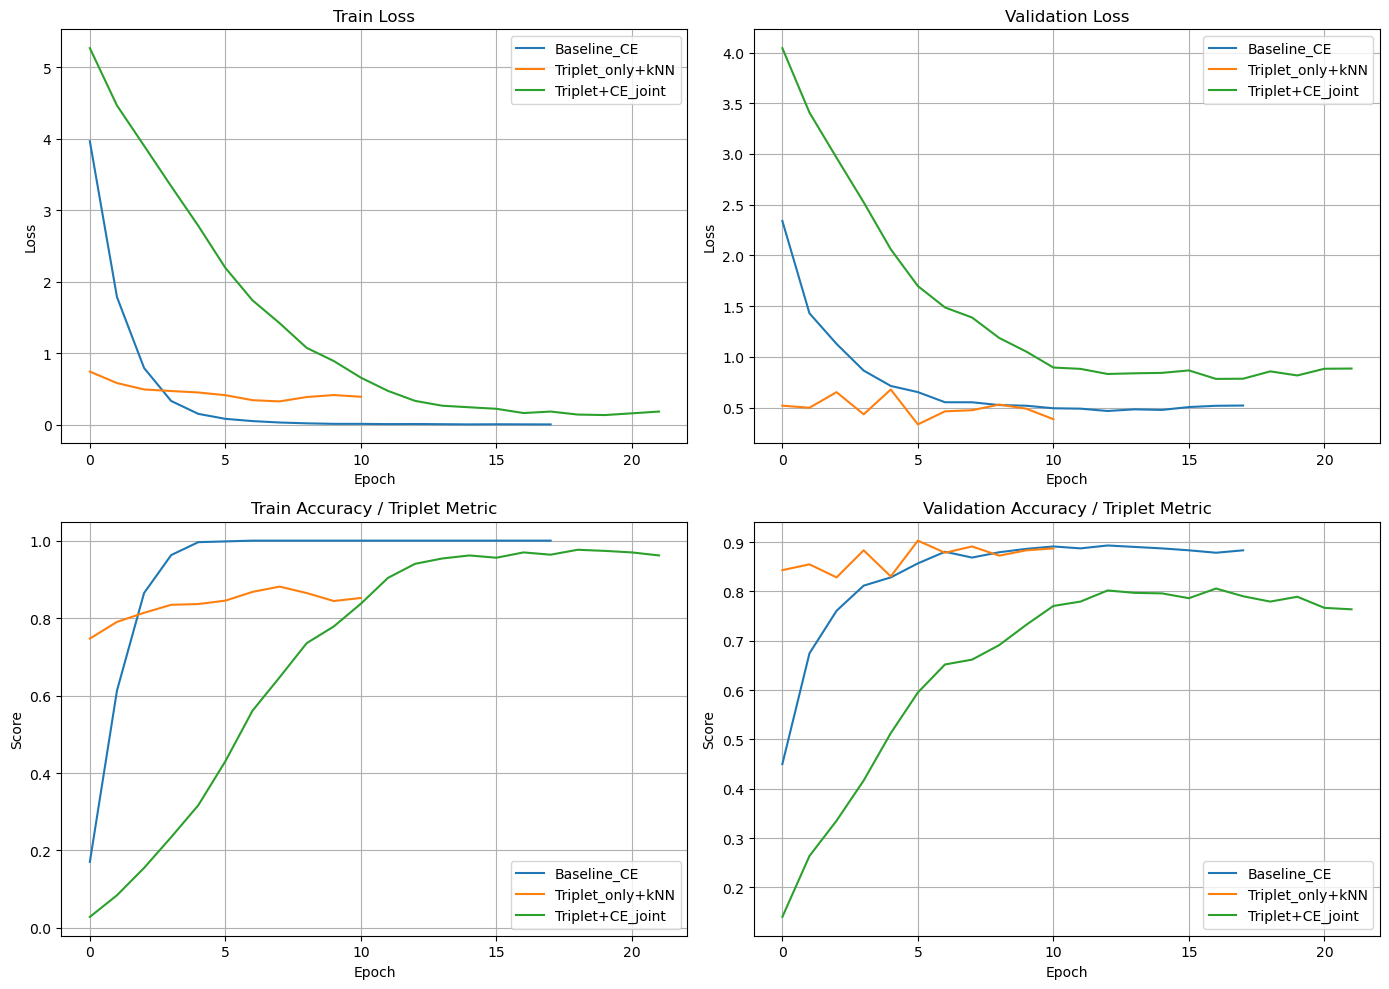

In [15]:
# Histories: Train/Val Loss & Accuracy for all variants

plt.figure(figsize=(14, 10))

# Train Loss
ax1 = plt.subplot(2, 2, 1)
for name in variant_names:
    ax1.plot(results[name]["train_loss"], label=name)
ax1.set_title("Train Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid(True)
ax1.legend()

# Val Loss
ax2 = plt.subplot(2, 2, 2)
for name in variant_names:
    ax2.plot(results[name]["val_loss"], label=name)
ax2.set_title("Validation Loss")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.grid(True)
ax2.legend()

# Train Acc / metric
ax3 = plt.subplot(2, 2, 3)
for name in variant_names:
    ax3.plot(results[name]["train_acc"], label=name)
ax3.set_title("Train Accuracy / Triplet Metric")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.grid(True)
ax3.legend()

# Val Acc / metric
ax4 = plt.subplot(2, 2, 4)
for name in variant_names:
    ax4.plot(results[name]["val_acc"], label=name)
ax4.set_title("Validation Accuracy / Triplet Metric")
ax4.set_xlabel("Epoch")
ax4.set_ylabel("Score")
ax4.grid(True)
ax4.legend()

plt.tight_layout()
plt.show()



Best variant by validation metric: Triplet_only+kNN


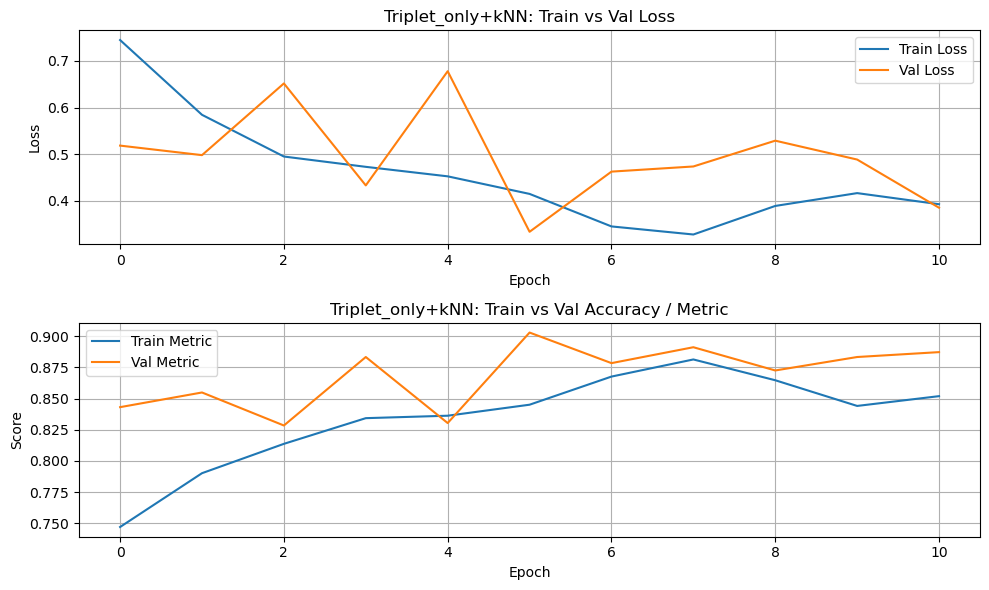

In [16]:
# Best Variant Detailed Curves

best_variant = max(results.items(), key=lambda kv: kv[1]["best_val_acc"])[0]
print("Best variant by validation metric:", best_variant)

bv = results[best_variant]

plt.figure(figsize=(10, 6))

# Loss
ax1 = plt.subplot(2, 1, 1)
ax1.plot(bv["train_loss"], label="Train Loss")
ax1.plot(bv["val_loss"], label="Val Loss")
ax1.set_title(f"{best_variant}: Train vs Val Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid(True)
ax1.legend()

# Accuracy / metric
ax2 = plt.subplot(2, 1, 2)
ax2.plot(bv["train_acc"], label="Train Metric")
ax2.plot(bv["val_acc"], label="Val Metric")
ax2.set_title(f"{best_variant}: Train vs Val Accuracy / Metric")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Score")
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()



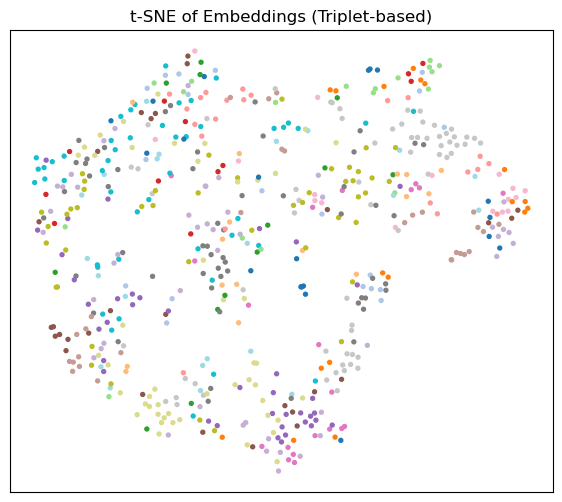

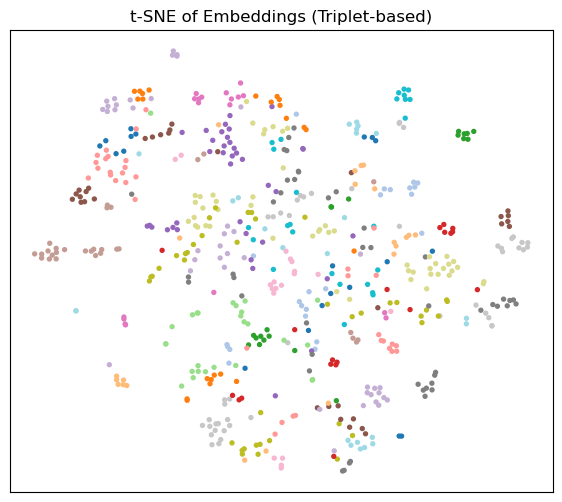

In [17]:
# Embedding Visualization for Triplet variants

def visualize_embeddings_tsne(model, loader, joint=False, num_points=600):
    embs, labels = extract_embeddings(model, loader, joint=joint)
    if embs.shape[0] > num_points:
        idx = np.random.choice(embs.shape[0], num_points, replace=False)
        embs = embs[idx]
        labels = labels[idx]
    tsne = TSNE(n_components=2, init="pca", learning_rate="auto")
    embs_2d = tsne.fit_transform(embs)
    plt.figure(figsize=(7, 6))
    scatter = plt.scatter(embs_2d[:, 0], embs_2d[:, 1], c=labels, s=8, cmap="tab20")
    plt.title("t-SNE of Embeddings (Triplet-based)")
    plt.xticks([])
    plt.yticks([])
    plt.show()

visualize_embeddings_tsne(results["Triplet_only+kNN"]["model"], test_loader, joint=False)
visualize_embeddings_tsne(results["Triplet+CE_joint"]["model"], test_loader, joint=True)



In [40]:
# Print summary table

print("\nSummary:")
for name in variant_names:
    r = results[name]
    print(
        f"{name:18s} | "
        f"Best Val: {r['best_val_acc']:.4f} | "
        f"Test Acc: {r['test_acc'] if r['test_acc'] is not None else float('nan'):.4f} | "
        f"Val ECE: {r['val_ece'] if r['val_ece'] is not None else float('nan'):.4f} | "
        f"Test ECE: {r['test_ece'] if r['test_ece'] is not None else float('nan'):.4f}"
    )

# ECE not applicable / not evaluated (non-probabilistic metric-learning + kNN)


Summary:
Baseline_CE        | Best Val: 0.8931 | Test Acc: 0.8567 | Val ECE: 0.0754 | Test ECE: 0.0698
Triplet_only+kNN   | Best Val: 0.9029 | Test Acc: 0.3511 | Val ECE: nan | Test ECE: nan
Triplet+CE_joint   | Best Val: 0.8059 | Test Acc: 0.7525 | Val ECE: 0.0387 | Test ECE: 0.0138
